# INTRODUCTION

In this Jupyter notebook we build a model to classify movie reviews using the IMDB dataset in Keras.  The first part of the notebook follows chapter 3.4 of the Deep Learning With Python (DLWP) book and replicates the baseline model.  The later parts of the notebook contain experiments intended to improve performance.

In [1]:
# modules
import itertools
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# shortcuts to submodules
imdb = tf.keras.datasets.imdb
models = tf.keras.models
layers = tf.keras.layers
optimizers = tf.keras.optimizers
losses = tf.keras.losses
metrics = tf.keras.metrics

In [2]:
NUM_WORDS = 10000

In [3]:
# import dataset of reviews and their labels
# limit review text to top 10000 commonly occuring words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = NUM_WORDS)
max_index_train = max([max(s) for s in train_data])
max_index_test = max([max(s) for s in test_data])
max_index = max([max_index_train, max_index_test])

In [4]:
print('summary of train_data')
print('---------------------')
print('type: ' + str(type(train_data)))
print('shape: ' + str(train_data.shape))
print('type of train_data[0]: ' + str(type(train_data[0])))
print('length of train_data[:5]: ' + str([len(train_data[i]) for i in range(5)]))
print('type of train_data[0][0]: ' + str(type(train_data[0][0])))
print('train_data[0][:10]: ' + str(train_data[0][:10]))
print('maximum entry in train_data and test_data: ' + str(max_index))
print()
print('summary of train_labels')
print('-----------------------')
print('type: ' + str(type(train_labels)))
print('shape: ' + str(train_labels.shape))
print('type of train_labels[0]: ' + str(type(train_labels[0])))
print('train_labels[:10]: ' + str(train_labels[:10]))
print('number of negative reviews: ' + str(np.sum(train_labels == 0)))
print('number of positive reviews: ' + str(np.sum(train_labels == 1)))
print()
print('summary of test_data')
print('--------------------')
print('shape: ' + str(test_data.shape))
print()
print('summary of test_labels')
print('----------------------')
print('shape: ' + str(test_labels.shape))
print('number of negative reviews: ' + str(np.sum(test_labels == 0)))
print('number of positive reviews: ' + str(np.sum(test_labels == 1)))

summary of train_data
---------------------
type: <class 'numpy.ndarray'>
shape: (25000,)
type of train_data[0]: <class 'list'>
length of train_data[:5]: [218, 189, 141, 550, 147]
type of train_data[0][0]: <class 'int'>
train_data[0][:10]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]
maximum entry in train_data and test_data: 9999

summary of train_labels
-----------------------
type: <class 'numpy.ndarray'>
shape: (25000,)
type of train_labels[0]: <class 'numpy.int64'>
train_labels[:10]: [1 0 0 1 0 0 1 0 1 0]
number of negative reviews: 12500
number of positive reviews: 12500

summary of test_data
--------------------
shape: (25000,)

summary of test_labels
----------------------
shape: (25000,)
number of negative reviews: 12500
number of positive reviews: 12500


In [5]:
# get word to index mapping and create reverse mapping from index to word
word_index = imdb.get_word_index()
reverse_word_index = { value:key for key,value in word_index.items() }

# helper function to decode index encoded reviews 
# index values 0, 1, 2 are reserved for "padding", "start of sequence", and "unknown"
def decode_review( encoded_review ) : 
    return ' '.join([reverse_word_index.get(i-3, '?') for i in encoded_review])

In [6]:
print()
print('number of entries word to index mapping dictionary: ' + str(len(word_index)))
print('number of entries index to word mapping dictionary: ' + str(len(reverse_word_index)))
print('low index values are common words: ' + str([reverse_word_index[i] for i in range(1,10)]))
print()
print('example of a positive review:')
print('-----------------------------')
positive_index = 6
print(decode_review(train_data[positive_index]))
print()
print('example of a negative review:')
print('-----------------------------')
negative_index = 2
print(decode_review(train_data[negative_index]))


number of entries word to index mapping dictionary: 88584
number of entries index to word mapping dictionary: 88584
low index values are common words: ['the', 'and', 'a', 'of', 'to', 'is', 'br', 'in', 'it']

example of a positive review:
-----------------------------
? lavish production values and solid performances in this straightforward adaption of jane ? satirical classic about the marriage game within and between the classes in ? 18th century england northam and paltrow are a ? mixture as friends who must pass through ? and lies to discover that they love each other good humor is a ? virtue which goes a long way towards explaining the ? of the aged source material which has been toned down a bit in its harsh ? i liked the look of the film and how shots were set up and i thought it didn't rely too much on ? of head shots like most other films of the 80s and 90s do very good results

example of a negative review:
-----------------------------
? this has to be one of the worst films

## Encoding
Encode each review as a 10000-dimensional vector.  Each component of this vector is 0 or 1 indicating the absence or presence of the corresponding word in the review.  An alternate encoding counts the number of times the corresponding word is present.

In [7]:
# binary encoding of reviews - 1 if word is present
def vectorize_sequences1( sequences, dimension = NUM_WORDS ):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i,sequence] = 1
    return results

# "histogram" encoding of reviews - counts number of times word is present
def vectorize_sequences2( sequences, dimension = NUM_WORDS ):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i,sequence] += 1
    return results

x_train = vectorize_sequences1(train_data)
x_test = vectorize_sequences1(test_data)

In [8]:
# vectorize labels -- don't know why this is necessary (int64-->float32?)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [9]:
# the model from the book
def build_model1():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape = (NUM_WORDS,)))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# same model with 2nd layer cut in half
def build_model2():
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape = (NUM_WORDS,)))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

In [10]:
model = build_model1()
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

W0830 09:02:52.190728 140377162016576 deprecation.py:506] From /home/shirish/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0830 09:02:52.246273 140377162016576 deprecation.py:323] From /home/shirish/anaconda3/envs/tf/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# set aside a validation set
VALIDATION_SIZE = 10000
from random import shuffle
index = list(range(x_train.shape[0]))
#shuffle(index)  # comment this out if non-random split is desired
x_val = x_train[index[:VALIDATION_SIZE]]
partial_x_train = x_train[index[VALIDATION_SIZE:]]
y_val = y_train[index[:VALIDATION_SIZE]]
partial_y_train = y_train[index[VALIDATION_SIZE:]]

In [12]:
# train model
history = model.fit(partial_x_train, partial_y_train, epochs = 20, 
                    batch_size = 512, validation_data = (x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 109us/sample - loss: 0.5119 - acc: 0.7878 - val_loss: 0.3847 - val_acc: 0.8641
Epoch 2/20
15000/15000 [==============================] - 1s 82us/sample - loss: 0.2975 - acc: 0.9053 - val_loss: 0.3081 - val_acc: 0.8809
Epoch 3/20
15000/15000 [==============================] - 1s 91us/sample - loss: 0.2195 - acc: 0.9259 - val_loss: 0.2760 - val_acc: 0.8926
Epoch 4/20
15000/15000 [==============================] - 1s 90us/sample - loss: 0.1743 - acc: 0.9421 - val_loss: 0.2756 - val_acc: 0.8904
Epoch 5/20
15000/15000 [==============================] - 1s 89us/sample - loss: 0.1387 - acc: 0.9569 - val_loss: 0.3303 - val_acc: 0.8740
Epoch 6/20
15000/15000 [==============================] - 1s 91us/sample - loss: 0.1165 - acc: 0.9643 - val_loss: 0.2946 - val_acc: 0.8863
Epoch 7/20
15000/15000 [==============================] - 1s 91us/sample - loss: 0.0964 - acc: 0.9708 - val_loss: 0

In [13]:
# extract logs of loss and accuracy
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc = history_dict['acc']
val_acc = history_dict['val_acc']
epochs = range(1,len(loss_values)+1)

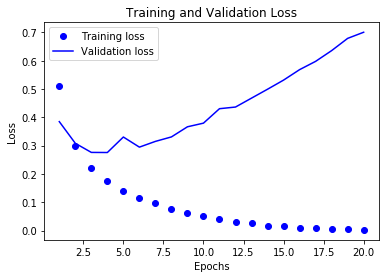

In [14]:
# plot loss for training and validation set
plt.clf()
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

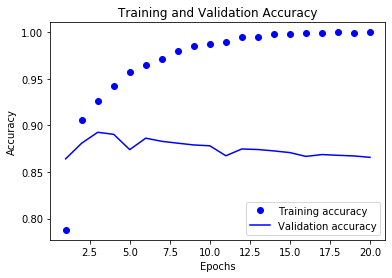

In [15]:
# plot accuracy for training and validation set
plt.clf()
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [16]:
# evaluate model on test set
results = model.evaluate(x_test, y_test)
print('test loss = ' + str(results[0]) + ', test accuracy = ' + str(results[1]))

25000/25000 [==============================] - 1s 57us/sample - loss: 0.7602 - acc: 0.8535
test loss = 0.7601951476812363, test accuracy = 0.85352


## Improvement
We now attempt to improve the test accuracy by choosing the words with which to represent the reviews in a different manner.  The approach thus far has kept the 10000 most frequently occurring words.  Some of these would be common words like "the", "of", "to", "and", etc.  It is reasonable to think that these words will not help separate the two classes of positive and negative reviews. Moreover, it is reasonable to think that there are classes of words associated with negative and positive reviews that should be included.

The conditional histograms (conditioned on positive or negative review) of word occurance frequencies are computed.  Then a score (between -1 and +1) is computed such that words that occur mainly in negative reviews get a score close to -1 and those in mostly positive reviews get a score close to +1.  Words that occur with equal frequencies get a score close to 0.

In [17]:
# reload data with no limits on words
(train_data, train_labels), (test_data, test_labels) = imdb.load_data()
max_index_train = max([max(s) for s in train_data])
max_index_test = max([max(s) for s in test_data])
max_index = max([max_index_train, max_index_test])

In [18]:
# create a histogram of frequency counts of each word conditioned on negative or positive review
flatlist0 = list(itertools.chain.from_iterable(train_data[train_labels == 0]))  # concatinate negative reviews
flatlist1 = list(itertools.chain.from_iterable(train_data[train_labels == 1]))  # concatinate positive reviews
freq0 = np.bincount(flatlist0, minlength = max_index+1)  # count occurance of each word
freq1 = np.bincount(flatlist1, minlength = max_index+1)
# hack to avoid divide by 0
both_zero = np.logical_and(freq0 == 0, freq1 == 0)
freq0[both_zero] = 1
freq1[both_zero] = 1
score = (freq1 - freq0)/(freq1 + freq0)

In [19]:
# create sets of negative, positive and neutral words
SIGNIFICANCE_THRESHOLD = 3
negative_words, = np.where(np.logical_and(score < -0.9, freq0 + freq1 > SIGNIFICANCE_THRESHOLD))
positive_words, = np.where(np.logical_and(score > 0.9, freq0 + freq1 > SIGNIFICANCE_THRESHOLD))
neutral_words, = np.where(np.logical_and(np.abs(score) < 0.25, freq0 + freq1 > SIGNIFICANCE_THRESHOLD))
assert(negative_words.shape[0]+positive_words.shape[0] <= NUM_WORDS)
print('NEGATIVE WORDS:')
print(', '.join([reverse_word_index.get(i-3,'?') for i in negative_words[:30]]))
print('POSITIVE WORDS:')
print(', '.join([reverse_word_index.get(i-3,'?') for i in positive_words[:30]]))
print('NEUTRAL WORDS:')
print(', '.join([reverse_word_index.get(i-3,'?') for i in neutral_words[:30]]))

NEGATIVE WORDS:
mst3k, seagal, boll, unwatchable, stinker, uwe, dreck, yawn, beowulf, gamera, thunderbirds, ajay, wayans, scarecrows, semblance, tashan, dahmer, slater, hobgoblins, kareena, awfulness, steaming, grendel, kornbluth, segal, sarne, deathstalker, btk, welch, tremors
POSITIVE WORDS:
felix, paulie, edie, gundam, polanski, din, antwone, vance, fido, sox, chavez, kolchak, gunga, alvin, excellently, mathieu, yokai, hayworth, gypo, tony's, deanna, laputa, haines, chamberlain, iturbi, adele, kells, sammo, flavia, gackt
NEUTRAL WORDS:
?, the, and, a, of, to, is, br, in, it, i, this, that, was, as, for, with, movie, but, film, on, not, you, are, his, have, he, be, one, all


In [20]:
# create list of 10000 included words to embed reviews
important_words = np.union1d(negative_words,positive_words)
remaining_words = np.setdiff1d(np.array(range(4,max_index+1)),np.union1d(important_words,neutral_words))
included_words = np.union1d(important_words,remaining_words[:NUM_WORDS-important_words.shape[0]])
included_words.sort()
print('INCLUDED WORDS:')
print(', '.join([reverse_word_index.get(i-3,'?') for i in included_words[:30]]))

INCLUDED WORDS:
no, bad, great, life, plot, best, love, why, thing, nothing, world, young, both, series, always, least, family, script, guy, anything, minutes, performance, 2, worst, fun, each, looks, different, money, reason


In [21]:
# create encoding using included words
included_words_map = np.zeros((max_index+2,), dtype='int64')
included_words_map[included_words] = np.array(list(range(included_words.shape[0])))+1  # zero reserved for unincluded word

# binary encoding of reviews - 1 if word is present
def vectorize_sequences3( sequences, dimension = NUM_WORDS ):
    results = np.zeros((len(sequences), dimension+1))
    for i, sequence in enumerate(sequences):
        idx = included_words_map[sequence]
        results[i,idx] = 1
    results = results[:,1:]  # remove unincluded word 
    return results# train model

x_train = vectorize_sequences3(train_data)
x_test = vectorize_sequences3(test_data)

In [22]:
# vectorize labels -- don't know why this is necessary (int64-->float32?)
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [23]:
model = build_model1()
model.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [24]:
# set aside a validation set
VALIDATION_SIZE = 10000
from random import shuffle
index = list(range(x_train.shape[0]))
#shuffle(index)  # comment this out if non-random split is desired
x_val = x_train[index[:VALIDATION_SIZE]]
partial_x_train = x_train[index[VALIDATION_SIZE:]]
y_val = y_train[index[:VALIDATION_SIZE]]
partial_y_train = y_train[index[VALIDATION_SIZE:]]

In [25]:
# train model
history = model.fit(partial_x_train, partial_y_train, epochs = 20, 
                    batch_size = 1024, validation_data = (x_val, y_val))

Train on 15000 samples, validate on 10000 samples
Epoch 1/20
15000/15000 [==============================] - 2s 116us/sample - loss: 0.5933 - acc: 0.8143 - val_loss: 0.4927 - val_acc: 0.8774
Epoch 2/20
15000/15000 [==============================] - 2s 104us/sample - loss: 0.4271 - acc: 0.9021 - val_loss: 0.3901 - val_acc: 0.8888
Epoch 3/20
15000/15000 [==============================] - 2s 102us/sample - loss: 0.3331 - acc: 0.9159 - val_loss: 0.3288 - val_acc: 0.8948
Epoch 4/20
15000/15000 [==============================] - 1s 98us/sample - loss: 0.2710 - acc: 0.9256 - val_loss: 0.2917 - val_acc: 0.8990
Epoch 5/20
15000/15000 [==============================] - 1s 99us/sample - loss: 0.2280 - acc: 0.9333 - val_loss: 0.2699 - val_acc: 0.9005
Epoch 6/20
15000/15000 [==============================] - 1s 98us/sample - loss: 0.1966 - acc: 0.9390 - val_loss: 0.2577 - val_acc: 0.9026
Epoch 7/20
15000/15000 [==============================] - 2s 102us/sample - loss: 0.1730 - acc: 0.9447 - val_loss

In [26]:
# evaluate model on test set
results = model.evaluate(x_test, y_test)
print('test loss = ' + str(results[0]) + ', test accuracy = ' + str(results[1]))

25000/25000 [==============================] - 2s 61us/sample - loss: 0.6019 - acc: 0.8368
test loss = 0.6019146831464768, test accuracy = 0.83684


## Conclusion
Inspite of carefully picking the list of 10000 words to represent our reviews, we only achieve a 2% improvement on the validation set and in fact lose accuracy on our test set by 2%.  It's possible we need to look at higher order word sequences (e.g. bigrams) to gain meaningful improvements.  Or this type of problem is best approached using RNNs.